#                        Projet-4 (Analysez les ventes de votre entreprise)

# Sommaire

# Mission 1: Nettoyage des données
1. Customer
2. Products
3. Transactions

# Mission 2 : Analyse des données
1. des indicateurs de tendance centrale et de dispersion ;

2. une analyse de concentration, via une courbe de Lorenz et un indice de Gini ;

3. des représentations graphiques, dont au moins un histogramme, une représentation avec des "boîtes à moustaches" ;

4.  une représentation de série temporelle (c’est-à-dire un graphique dont l’axe des abscisses représente des dates) ;

4. des analyses bivariées.

# Mission 3: Étude des Corrélations
1. corrélation entre le sexe des clients et les catégories de produits achetés 

2. une corrélation entre l'âge des clients et le montant total des achats ;

3. une corrélation entre l'âge des clients et la fréquence d’achat (ie. nombre d'achats par mois par exemple) ;

4. une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ;

5. une corrélation entre l'âge des clients et les catégories de produits achetés.

In [1]:
import pandas as pd ; 
import numpy as np ; 
import seaborn as sns ; 
import datetime as dt ; 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import arange, plot 
from matplotlib.pyplot import figure
import scipy.stats as st 
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import warnings ; warnings.filterwarnings('ignore')

# Import all data files.csv

In [20]:
ventes_1=pd.read_csv("ventes_1.csv")
df_transactions=pd.read_csv("transactions.csv",parse_dates=[1])
df_customers=pd.read_csv("customers.csv", dtype={'sex': 'category'})
df_produits=pd.read_csv("products.csv", dtype={'categ': 'category'})

# Mission n° 2:  Analyse des données


Effectuez d'abord l'agrégation par mois

In [4]:
# Lists for our aggregations:
CALENDAR=["janvier", "fevrier", "mars", "avril", "mai", "juin", 
          "juillet", "août", "septembre", "octobre", "novembre", "decembre"]
CHRONOLOGIE=[22.01, 22.02, 21.03, 21.04, 21.05, 21.06, 21.07, 21.08, 21.09, 21.10, 21.11, 21.12]

# To change, for example, from "July" to 7:
def nombre_mois(car):
    return(CALENDAR.index(car)+1)

# To change, for example, from 4 to "April":          
def nom_mois(n):
    return(CALENDAR[n-1])
    
# To move, for example, from "April" to "21.04" or from "January" to "22.01":
def chronologie(car):
    return(CHRONOLOGIE[nombre_mois(car)-1])

# Variables supplémentaires
Notez qu'une "session" est un groupe d'achats. Il serait donc intéressant de savoir combien de livres ont été achetés dans chaque session. Nous créons donc la variable "basket_size" qui nous donnera cette indication.

In [5]:
ventes_1["basket_size"]=ventes_1["session_id"].value_counts()[ventes_1["session_id"]].tolist()
ventes_1.head(3)

,Unnamed: 0,id_prod,session_id,client_id,date,heure,price,categ,sex,birth,age,basket_size
0,0,0_1483,s_18746,c_4450,2021-04-10,00:00:00,4.99,0,f,1977,44,3
1,1,2_226,s_159142,c_277,2022-02-03,00:00:00,65.75,2,f,2000,21,2
2,2,1_374,s_94290,c_4270,2021-09-23,00:00:00,10.71,1,f,1979,42,9


In [6]:
# The date is converted back to datetime:
ventes_1["date"]=pd.to_datetime(ventes_1["date"])

In [7]:
# We add the column "month" to our functions:
ventes_1["mois"]=ventes_1["date"].dt.month.apply(nom_mois)

In [8]:
# And the day of the month, it will be useful:
ventes_1["jour"]=ventes_1["date"].dt.day

In [9]:
# We reindex our data to see more clearly:
ventes_2=ventes_1.reindex(columns=["id_prod", "categ", "price", "client_id", "sex", "age", "session_id", "basket_size",
                             "date", "mois", "jour"])
ventes_2.head()

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour
0,0_1483,0,4.99,c_4450,f,44,s_18746,3,2021-04-10,avril,10
1,2_226,2,65.75,c_277,f,21,s_159142,2,2022-02-03,fevrier,3
2,1_374,1,10.71,c_4270,f,42,s_94290,9,2021-09-23,septembre,23
3,0_2186,0,4.20,c_4597,m,58,s_105936,1,2021-10-17,octobre,17
4,0_1351,0,8.99,c_1242,f,41,s_63642,2,2021-07-17,juillet,17


# Pour faire diverses observations graphiques sur les ventes réalisées de mars 2021 à février 2022. 

In [10]:
def couleur(c):
    if c==0: return("steelblue")
    elif c==1: return("crimson") 
    else: return("goldenrod") 
#Ce sera notre couleur de repère pour la catégorie.

In [11]:
# color palette for the 3 categories.
palette=[couleur(c) for c in range(3)] 
categories_3 = ["Catégorie %d" %i for i in range(3)]

In [12]:
# Several individual studies will be conducted on the sales of each category of books:
[categ_0, categ_1, categ_2] = [ventes_2.loc[ventes_2["categ"]==i] for i in range(3)]

In [13]:
# A function to easily perform a groupby on a table:
def groupby_var(data, var):
    return(pd.DataFrame(data.groupby(var).sum()["price"]).reset_index())

In [14]:
# A function that reorders our data chronologically (from March to February):
def periode(data):
    data["chronologie"]=data["mois"].apply(chronologie)
    data=data.sort_values(by="chronologie")
    data.drop(columns="chronologie", inplace=True)
    return(data)

In [15]:
# The dim() function will allow us to define each time the dimensions of the figures that we will display:
def dim(x, y): return(plt.figure(figsize=(x, y)))

In [16]:
# Here we define the parameters of the boxplots and pie charts for the whole mission:
medianprops = {"color":"black"}
meanprops = {"marker":"o", "markeredgecolor":"black", "markerfacecolor":"firebrick"}
autopct=lambda x: str(round(x, 2))+"%"

In [17]:
# The boxplot() function which will return the boxplot of the X and Y variables of data:
def boxplot(data, X, Y):
    categories = data[X].unique() ; CAT=[]
    for i in categories:
        CAT.append(data[data[X]==i][Y])
    return(dim(18, 3), plt.boxplot(CAT, labels=categories, showfliers=False, medianprops=medianprops, 
                                   vert=False, patch_artist=True, showmeans=True, meanprops=meanprops))

In [18]:
ventes_2

,id_prod,categ,price,client_id,sex,age,session_id,basket_size,date,mois,jour
0,0_1483,0,4.99,c_4450,f,44,s_18746,3,2021-04-10,avril,10
1,2_226,2,65.75,c_277,f,21,s_159142,2,2022-02-03,fevrier,3
2,1_374,1,10.71,c_4270,f,42,s_94290,9,2021-09-23,septembre,23
3,0_2186,0,4.20,c_4597,m,58,s_105936,1,2021-10-17,octobre,17
4,0_1351,0,8.99,c_1242,f,41,s_63642,2,2021-07-17,juillet,17
...,...,...,...,...,...,...,...,...,...,...,...
336811,1_671,1,31.99,c_3454,m,52,s_40720,1,2021-05-28,mai,28
336812,0_759,0,22.99,c_6268,m,30,s_50568,2,2021-06-19,juin,19
336813,0_1256,0,11.03,c_4137,f,53,s_7219,1,2021-03-16,mars,16
336814,2_227,2,50.99,c_5,f,27,s_112349,1,2021-10-30,octobre,30


réutiliser le DataFrame "customers", où nous ajoutons la colonne "is_active" qui renvoie "ACTIVE" si le client en question a effectué au moins un achat pendant la période d'étude (mars 2021 - février 2022), "INACTIVE" sinon

In [21]:
def active(cus):
    if cus==True: return("Active")
    else: ("Inactive")
df_customers['is active']=df_customers['client_id'].isin(ventes_2.client_id).apply(active)
df_customers.head()

,client_id,sex,birth,is active
0,c_4410,f,1967,Active
1,c_7839,f,1975,Active
2,c_1699,f,1984,Active
3,c_5961,f,1962,Active
4,c_5320,m,1943,Active


nous allons étudier les sessions d'achat et créer le DataFrame "sessions" qui rassemble les montants totaux de chaque session d'achat effectuée sur le site au cours de l'année.

In [22]:
session = pd.DataFrame(ventes_2.groupby(["session_id", "client_id", "age", "date", "mois", "jour"])
                        .sum()["price"]).reset_index()

session.rename(columns={"price": "montant_session"}, inplace=True)
effectif = pd.DataFrame(ventes_2.session_id.value_counts().reset_index())
effectif.columns=("session_id", "taille_panier")
session=pd.merge(session, effectif)
session.head()

,session_id,client_id,age,date,mois,jour,montant_session,taille_panier
0,s_1,c_329,54,2021-03-01,mars,1,11.99,1
1,s_10,c_2218,51,2021-03-01,mars,1,26.99,1
2,s_100,c_3854,43,2021-03-01,mars,1,33.72,2
3,s_1000,c_1014,32,2021-03-03,mars,3,39.22,4
4,s_10000,c_476,32,2021-03-22,mars,22,41.49,3


# Pour l’analyse univariée

# a. Les caractéristiques des ventes (min, moyenne, max, écart-type)

In [23]:
ventes_2.describe()

,categ,price,age,basket_size,jour
count,336816.000000,336816.000000,336816.000000,336816.000000,336816.000000
mean,0.430024,17.213896,43.176604,2.806357,15.801639
std,0.591039,17.852868,13.523923,1.632952,8.818361
min,0.000000,0.620000,17.000000,1.000000,1.000000
25%,0.000000,8.610000,34.000000,2.000000,8.000000
50%,0.000000,13.900000,41.000000,2.000000,16.000000
75%,1.000000,18.990000,50.000000,4.000000,23.000000
max,2.000000,300.000000,92.000000,14.000000,31.000000


# b. L’évolution des ventes dans le temps

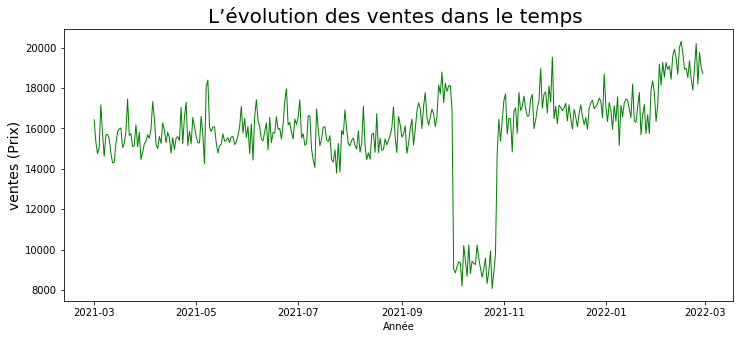

In [24]:
ventes_date = groupby_var(ventes_2, "date") 
dim(12, 5)
plt.plot(ventes_date["date"], ventes_date["price"], color="green", label="ventes", linewidth=1)

plt.title("L’évolution des ventes dans le temps ", fontsize=20)
plt.xlabel("Année") ; plt.ylabel("ventes (Prix)", fontsize=14) ; plt.show()

On peut constater une tendance à la hausse de cette évolution tout au long de l'année, avec interruption entre septembre et novembre avec une forte baisse des ventes

# Observons l'évolution du Chiffre d'affaires de mars 2021 à février 2022 par catégorie.

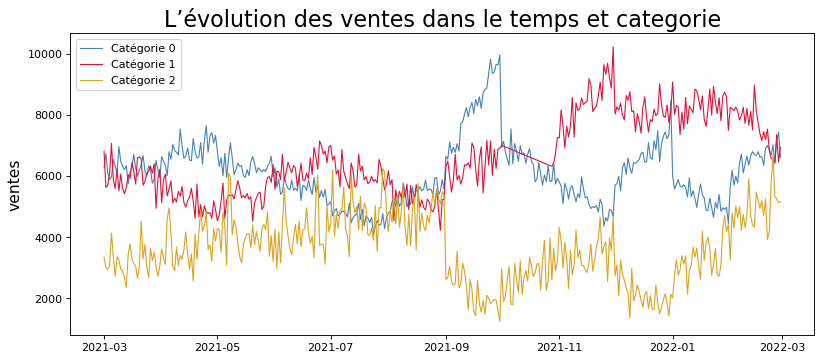

In [25]:
figure(num=None, figsize=(12, 5), dpi=80)
for i in range(3):
    cate=groupby_var(ventes_2.loc[ventes_2["categ"]==i], "date")
    color=couleur(i)
    plt.plot(cate["date"], cate["price"], color=color, linewidth=1, label= "Catégorie %d" %i)

plt.title("L’évolution des ventes dans le temps et categorie", fontsize=20)
plt.xlabel("") ; plt.ylabel("ventes", fontsize=14)
plt.legend() 
plt.show()

Ici, observe ventes plus faible pour la catégorie 2. 
Mais la chute des ventes pour les trois catégories de livres autour de novembre.

# c. L’évolution des ventes par mois

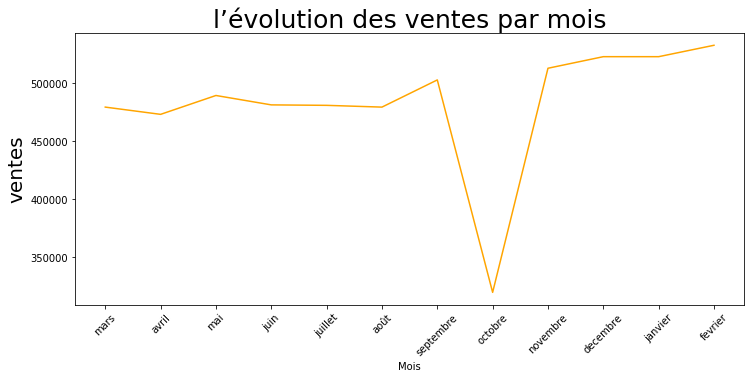

In [26]:
Evolution_mensuelle = groupby_var(ventes_2, "mois")
Evolution_mensuelle["chronologie"]=Evolution_mensuelle["mois"].apply(chronologie)
Evolution_mensuelle=Evolution_mensuelle.sort_values(by="chronologie")

dim(12, 5) ; plt.plot(Evolution_mensuelle["mois"], Evolution_mensuelle["price"], color="orange")
plt.title("l’évolution des ventes par mois", fontsize=25)
plt.xlabel("Mois") ; plt.ylabel("ventes", fontsize=20) 
plt.xticks(rotation=45) 
plt.show()

C'est là que l'on peut constater la chute drastique du chiffre d'affaires en octobre. 

# d. L’évolution de la contribution et la contribution de chaque catégorie aux ventes

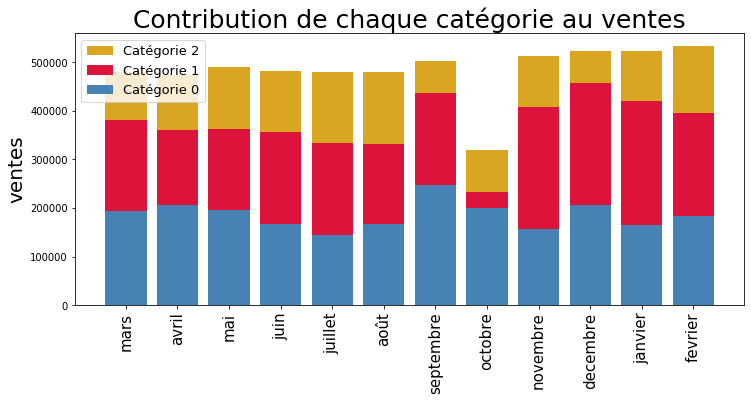

In [27]:
Evolution_mensuelle_cat=periode(ventes_2.pivot_table(index="mois", columns="categ", values="price", aggfunc=sum).reset_index())
Evolution_mensuelle_cat.columns=["mois", "categ_0", "categ_1", "categ_2"] ; dim(12, 5)

plt.bar(Evolution_mensuelle_cat.mois, Evolution_mensuelle_cat.categ_0 + Evolution_mensuelle_cat.categ_1 + Evolution_mensuelle_cat.categ_2, color=couleur(2), label="Catégorie 2")
plt.bar(Evolution_mensuelle_cat.mois, Evolution_mensuelle_cat.categ_0 + Evolution_mensuelle_cat.categ_1, color=couleur(1), label="Catégorie 1")
plt.bar(Evolution_mensuelle_cat.mois, Evolution_mensuelle_cat.categ_0, color=couleur(0), label="Catégorie 0")

plt.title("Contribution de chaque catégorie au ventes", fontsize=25) ; plt.legend(loc=" left", fontsize=13)
plt.xlabel("") ; plt.xticks(rotation= "vertical", fontsize=15) ; plt.ylabel("ventes", fontsize=20)  ; plt.show()

# e. La contribution de chaque catégorie aux ventes

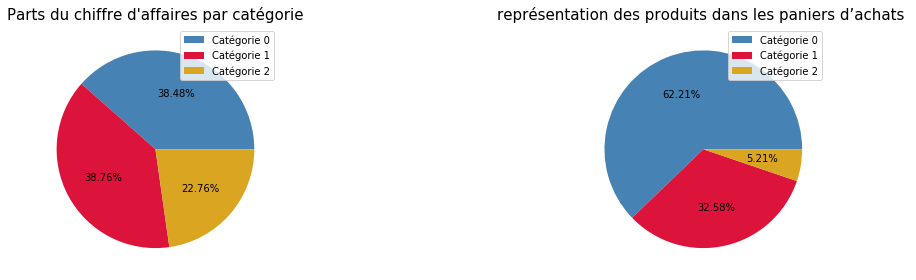

In [28]:
dim(18, 10) ; plt.subplot(2, 2, 1)
groupby_var(ventes_2, "categ")["price"].plot(kind="pie", colors=palette, labels=["", "", ""], autopct=autopct)
plt.title("Parts du chiffre d'affaires par catégorie", fontsize=15) 
plt.ylabel("")
plt.legend(categories_3, loc="left")

plt.subplot(2, 2, 2)
ventes_2["categ"].value_counts(normalize=True).plot(kind="pie", colors=palette, labels=["", "", ""], autopct=autopct)
plt.title("représentation des produits dans les paniers d’achats ", fontsize=15) ; plt.ylabel("")
plt.legend(categories_3, loc=" left") 
plt.show()

Comparaison des deux diagrammes circulaires :

catégorie 0: se vendent bien et représentent le plus grand nombre de ventes (62,21%).

catégorie 1: sont les plus vendus (plus forte contribution au Chiffre d’affaires), malgré un nombre de ventes largement inférieure à celui de la catégorie 0.

catégorie 2: moins solliciter (5,21% des paniers) et contribuent le moins aux ventes. 

la comparaison entre le taux de vente et la participation aux ventes suggère que les livres de catégorie 2 sont globalement les livres les plus chers de notre inventaire.

# f. La distribution des âges des clients 

(array([25622., 30708., 80377., 85605., 55362., 22549., 21349.,  8316.,
         5515.,  1413.]),
 array([17. , 24.5, 32. , 39.5, 47. , 54.5, 62. , 69.5, 77. , 84.5, 92. ]),
 <a list of 10 Patch objects>)

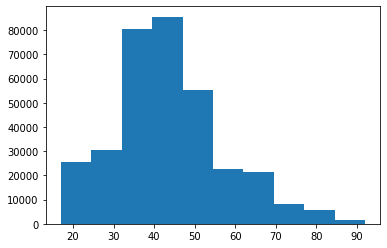

In [30]:
plt.hist(ventes_2['age'])

Nous pouvons constater que l'âge médian des clients, hommes et femmes, se situe entre 40 et 45 ans. 

# g. La répartition des clients par sexe

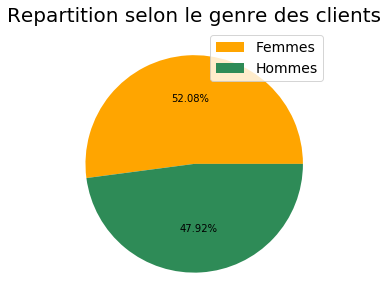

In [29]:
dim(5, 5)
df_customers["sex"].value_counts().plot(kind="pie", colors=["orange","seagreen"], labels=[""]*2, autopct=autopct)

plt.title("Repartition selon le genre des clients", fontsize=20)
plt.ylabel("")
plt.legend(["Femmes", "Hommes"], loc="left", fontsize=14) 
plt.show()

La proportion des clients âgés de 18 ans est la plus élevée et pourrait s’expliquer par une contrainte d’accès au site.
Ce diagramme circulaire montre clairement que les clients sont majoritairement constituées de femmes (52,08%). 

# h. Analyse de la distribution du nombre d’achats par client à travers la courbe de Lorenz

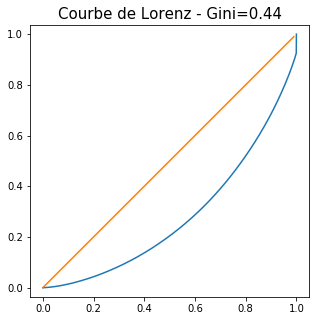

In [31]:
clients=pd.DataFrame(ventes_2.groupby("client_id").sum()["price"]).sort_values("price")
depenses = clients.price.values
n = len(depenses)

lorenz = np.append([0], np.cumsum(depenses)/sum(depenses))
gini=2*(0.5-lorenz.sum()/n)

dim(5, 5) ; plt.plot(np.linspace(0-1/n, 1+1/n, n+1), lorenz)
plt.axes().axis("equal") ; plt.title("Courbe de Lorenz - Gini=%s" %(round(gini, 2)), fontsize=15)

X = arange(0,1,0.01) ; Y=X
plot(X, Y) ; plt.show()

On observe alors sur la courbe de Lorenz, avec un indice de Gini proche de 0,44 que
distribution du nombre d’achats par client n'est pas égalitaire.

Ainsi, les achats ne sont pas distribués de manière égale entre les clients ; les gros achats effectués par quelques clients ne sont pas distribués à tous les clients. 
Si les achats effectués par chaque client et dépensent chaque montant d'argent. Alors la valeur de Gini serait égale à zéro. 


# Analyse descriptive bivariée


# a. Analyse des ventes par catégories de produits

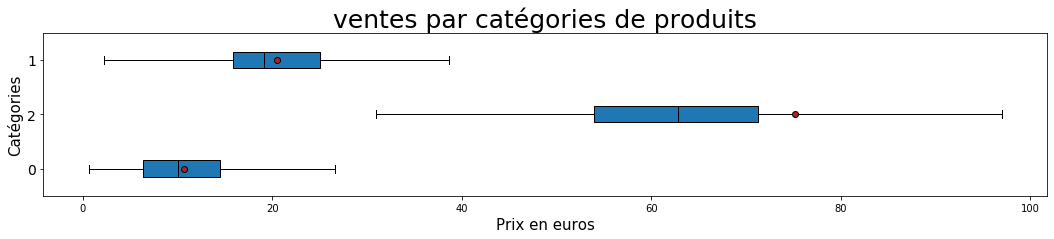

In [33]:
boxplot(ventes_2, 'categ', 'price')
plt.title("ventes par catégories de produits", fontsize=25)
plt.xlabel("Prix en euros", fontsize=15) ; plt.ylabel("Catégories", fontsize=15) ; plt.yticks(fontsize=14) ; plt.show()

CATÉGORIE 0 : Les prix varient de 0 à 30 euros. En moyenne, ces livres coûtent environ 10 euros et la plupart d'entre eux se vendent à bas prix euros. D'après le graphique ci-dessus, il s'agit de la catégorie "la moins chère".
    
CATÉGORIE 1 : Les prix vont de plus de 0 à 40 euros. Cette catégorie semble convenir à tous les portefeuilles.
    
CATÉGORIE 2 : Les prix vont de 30 euros à 100 euros, c'est la catégorie "la plus chère". C'est aussi la catégorie de livres qui offre le plus grand choix en termes de prix

# b. Analyse des ventes par sexe du client


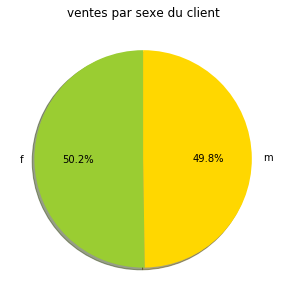

In [88]:
labels = ventes_2.sex.cat.categories
values = ventes_2.sex.value_counts()
colors = ['yellowgreen', 'gold']
plt.figure(1, figsize=(5, 5))
plt.title('ventes par sexe du client')
trace = plt.pie(values, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)

Dans cette analyse des ventes par sexe du client, on peut observer que la contribution des femmes (50,2%) est un peu plus élevée que celle des hommes (49,8%). 
Donc les ventes des femmes sont plus nombreuses que celles des hommes


# c. Analyse des ventes par tranche d’âges

In [36]:
M_number = ventes_2.age[ventes_2.sex=='m']
F_number = ventes_2.age[ventes_2.sex=='f']
tranches = [10,20,30,40,50,60,70,80,90]

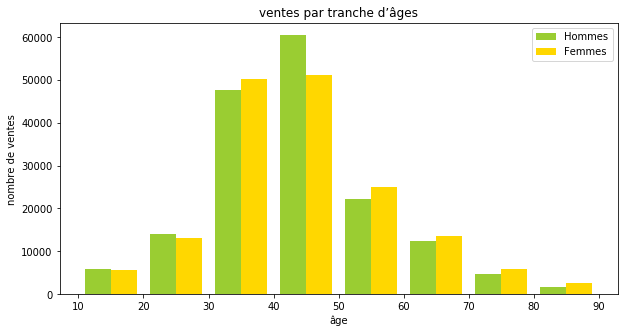

In [37]:
plt.figure(1, figsize=(10, 5))
plt.title("ventes par tranche d’âges")
plt.hist([M_number, F_number], bins = tranches, color = ['yellowgreen', 'gold'])
labels = ['Hommes', 'Femmes']
plt.legend(labels)
plt.xlabel('âge')
plt.ylabel('nombre de ventes')
plt.show()

# d. Analyse des catégories de produits achetés en fonction de l’âge du client 

In [38]:
def get_tranche(a):
    if a<=20: return("etudiant")
    elif a<=50: return("actif")
    else: return("senior")

In [39]:
# Ajout de la colonne "tranche":
ventes_1["tranche"]=ventes_1["age"].apply(get_tranche)
age_table=ventes_1.reset_index(drop=True) ; 
age_table

,Unnamed: 0,id_prod,session_id,client_id,date,heure,price,categ,sex,birth,age,tranche
0,0,0_1483,s_18746,c_4450,2021-04-10,00:00:00,4.99,0,f,1977,44,actif
1,1,2_226,s_159142,c_277,2022-02-03,00:00:00,65.75,2,f,2000,21,actif
2,2,1_374,s_94290,c_4270,2021-09-23,00:00:00,10.71,1,f,1979,42,actif
3,3,0_2186,s_105936,c_4597,2021-10-17,00:00:00,4.20,0,m,1963,58,senior
4,4,0_1351,s_63642,c_1242,2021-07-17,00:00:00,8.99,0,f,1980,41,actif
...,...,...,...,...,...,...,...,...,...,...,...,...
336811,336811,1_671,s_40720,c_3454,2021-05-28,00:00:00,31.99,1,m,1969,52,senior
336812,336812,0_759,s_50568,c_6268,2021-06-19,00:00:00,22.99,0,m,1991,30,actif
336813,336813,0_1256,s_7219,c_4137,2021-03-16,00:00:00,11.03,0,f,1968,53,senior
336814,336814,2_227,s_112349,c_5,2021-10-30,00:00:00,50.99,2,f,1994,27,actif


In [40]:
df_age=pd.crosstab(age_table.categ, age_table.tranche)
df_age

tranche,actif,etudiant,senior
categ,,,
0,168509,3115,37905
1,59256,5138,45341
2,11215,5533,804


In [41]:
df_age_1=pd.crosstab(age_table.categ, age_table.tranche,normalize="index").round(4)*100
df_age_1

tranche,actif,etudiant,senior
categ,,,
0,80.42,1.49,18.09
1,54.00,4.68,41.32
2,63.90,31.52,4.58


Text(0.5, 1.0, 'catégories de produits achetés en fonction de l’âge du client')

<Figure size 1800x720 with 0 Axes>

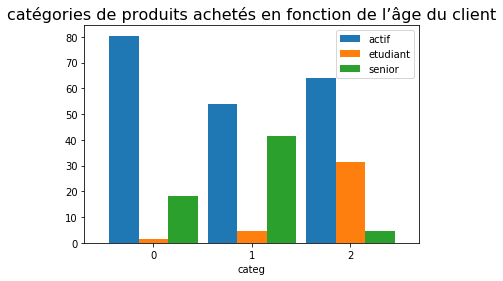

In [42]:
plt.figure(figsize=(25, 10)) 
df_age_1.plot(kind='bar',width=0.9,stacked=False, rot=0)
plt.legend(labels=df_age_1.columns,fontsize= 10)
plt.title("catégories de produits achetés en fonction de l’âge du client",fontsize= 16)

Nous pouvons clairement voir avec ce graphique que les clients actifs ont acheté plus de produits dans chaque catégorie.

Ensuite, les étudiants ont également acheté un bon pourcentage de produits de la catégorie 2 qui sont chers par rapport aux deux autres produits.  

Ainsi, il est clair que les étudiants ne font pas attention au coût, ils achètent s'ils en ont besoin. 

De plus, un bon pourcentage de livres de catégorie 1 est également acheté par des clients seniors. 

Les seniors ne dépensent donc pas d'argent pour des livres chers, ils optent pour des produits de moyenne gamme


# e. Analyse des catégories de produits achetés en fonction du sexe du client

In [43]:
df2=pd.crosstab(ventes_1.categ, ventes_1.sex,normalize="index").round(4)*100
df2

sex,f,m
categ,,
0,49.56,50.44
1,50.55,49.45
2,47.06,52.94


Text(0.5, 1.0, 'catégories de produits achetés en fonction du sexe du client')

<Figure size 1440x1800 with 0 Axes>

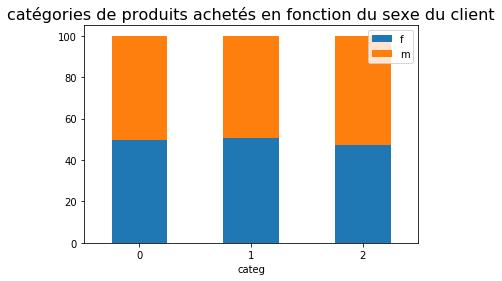

In [44]:
dim(20,25)
df2.plot(kind='bar',stacked=True, rot=0)
plt.legend(labels=df2.columns,fontsize= 10)
plt.title("catégories de produits achetés en fonction du sexe du client",fontsize= 16)

CATÉGORIE 0 : Les achats de produits par les femmes (49,56%) sont un peu moins élevés que ceux des hommes (50,44%).
    
CATÉGORIE  1 : Les achats de produits par les femmes (51,55%) sont un peu plus élevés que ceux des hommes (48,45%).
    
CATÉGORIE  2 : Les produits achetés par les femmes (47,20%) sont un peu moins que ceux achetés par les hommes (52,94%).


# Mission n° 3 Correlation

# a. Corrélation entre le sexe du client et l'achat de catégories de produits


In [46]:
import scipy as sp
import scipy.stats as stat

In [47]:
corr_Sex_Cat = pd.crosstab(ventes_2.sex,ventes_2.categ).astype(np.float64)
corr_Sex_Cat.columns.name = 'Table'
corr_Sex_Cat = corr_Sex_Cat.reindex(['f','m'])
corr_Sex_Cat.round()

Table,0,1,2
sex,,,
f,103846.0,55469.0,8260.0
m,105683.0,54266.0,9292.0


In [48]:
corr_Sex_Cat_analysis= sp.stats.chi2_contingency(corr_Sex_Cat)
ar=corr_Sex_Cat_analysis[3]

In [49]:
contingency = pd.DataFrame(ar, index = ['f', 'm'], columns = ['0', '1', '2']).round()
contingency.columns.name = "Tableau d'indépendance"

In [50]:
contingency

Tableau d'indépendance,0,1,2
f,104246.0,54596.0,8733.0
m,105283.0,55139.0,8819.0


In [51]:
chi2 = (corr_Sex_Cat-ar)**2/ar
chi2.columns.name = 'Measure du chi-2'
chi2.round()

Measure du chi-2,0,1,2
sex,,,
f,2.0,14.0,26.0
m,2.0,14.0,25.0


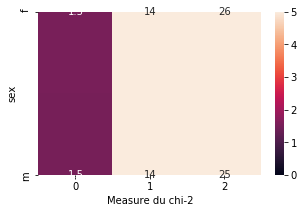

In [52]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(chi2, annot=True, vmin=0, vmax=5)

Conclusion:

Catégorie 0 : Les hommes semblent être plus intéressés par cette catégorie de livres que les femmes.

Catégorie 1 : On constate ici que les femmes sont beaucoup plus intéressées par cette catégorie que les hommes.

Catégorie 2 : Les hommes sont aussi souvent intéressés par cette catégorie de livres que les femmes.


In [53]:
print('le test chi-2 global présente une statistique de',corr_Sex_Cat_analysis[0].round(2))
print('et une p-value de',corr_Sex_Cat_analysis[1],'inférieure à alpha = 0.05%')
print("l'hypothèse nulle est rejetée, il existe une corrélation entre le sexe et la catégorie de produit")

le test chi-2 global présente une statistique de 81.73
et une p-value de 1.7857752515034613e-18 inférieure à alpha = 0.05%
l'hypothèse nulle est rejetée, il existe une corrélation entre le sexe et la catégorie de produit


# b. Corrélation entre age et montant des achats

In [54]:
montant = ventes_1.groupby('age').price.sum()
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(montant.index,montant)
line = slope*montant.index+intercept

le modèle linéaire est de la forme : y = ax + b
et a = -2265.262050307615
avec b = 199745.1467417662
et un R² de  0.6000541961960478


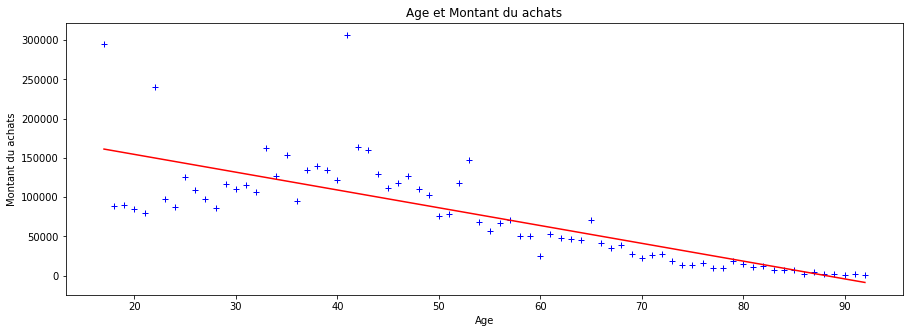

In [55]:
plt.figure(1, figsize=(15, 5))
plt.plot(montant.index, montant, color = 'blue', marker = '+', linestyle = 'none')
plt.plot(montant.index, line, color = 'red')
plt.title('Age et Montant du achats')
plt.xlabel('Age')
plt.ylabel('Montant du achats')
print('le modèle linéaire est de la forme : y = ax + b')
print('et a =',slope)
print('avec b =', intercept)
print('et un R² de ', r_value**2)

In [56]:
stat_freq = {'pearson' : sp.stats.pearsonr(montant,montant.index)}
pd.DataFrame(stat_freq).round(2).rename(index={0:'Valeur du test',1:'P-Value'})

,pearson
Valeur du test,-0.77
P-Value,0.00


La valeur de R-2 est prédite 0,60, ce qui signifie 60 %, ce qui constitue un bon modèle de régression linéaire négative. 
Les clients les plus âgés dépensent moins en un an que les jeunes clients. 

# c. Corrélation entre age et fréquence d'achat

In [57]:
frequence = ventes_1.groupby('age').id_prod.count()
slope2, intercept2, r_value2, p_value2, std_err2 = sp.stats.linregress(frequence.index,frequence)
line2 = slope2*frequence.index+intercept2

le modèle linéaire est de la forme : y = ax + b
et a = -104.2761722488038
avec b = 10114.840861244018
et un R² de  0.2801137349989304


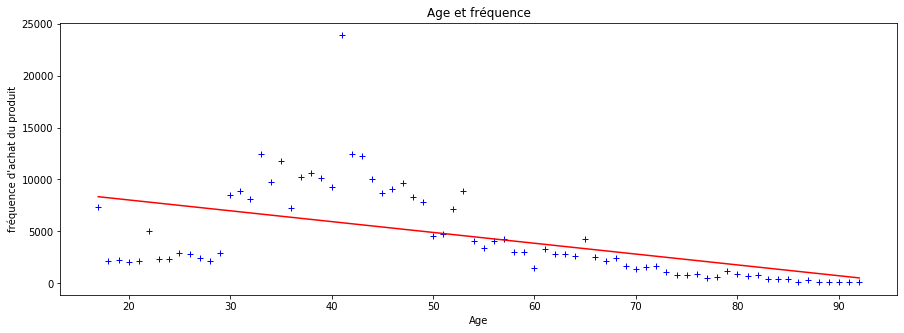

In [58]:
plt.figure(1, figsize=(15, 5))
plt.plot(frequence.index, frequence, color = 'blue', marker = '+', linestyle = 'none')
plt.plot(frequence.index, line2, color = 'red')
plt.title('Age et fréquence')
plt.xlabel('Age')
plt.ylabel("fréquence d'achat du produit")
print('le modèle linéaire est de la forme : y = ax + b')
print('et a =',slope2)
print('avec b =', intercept2)
print('et un R² de ', r_value2**2)

Value of R-2 is predicted 0.28 means 28% so this is not very good linear regression model.

In [59]:
stat_freq = {'pearson' : sp.stats.pearsonr(frequence,frequence.index)}
pd.DataFrame(stat_freq).round(2).rename(index={0:'Valeur du test',1:'P-Value'})

,pearson
Valeur du test,-0.53
P-Value,0.00


In [60]:
a30 = frequence[(frequence.index > 30) & (frequence < 15000)]

In [61]:
slopea30, intercepta30, r_valuea30, p_valuea30, std_erra30 = sp.stats.linregress(a30.index,a30)
linea30 = slopea30*a30.index+intercepta30

le modèle linéaire est de la forme : y = ax + b
et a = -204.90443748787052
avec b = 17023.35308531553
et un R² de  0.8407693764163361


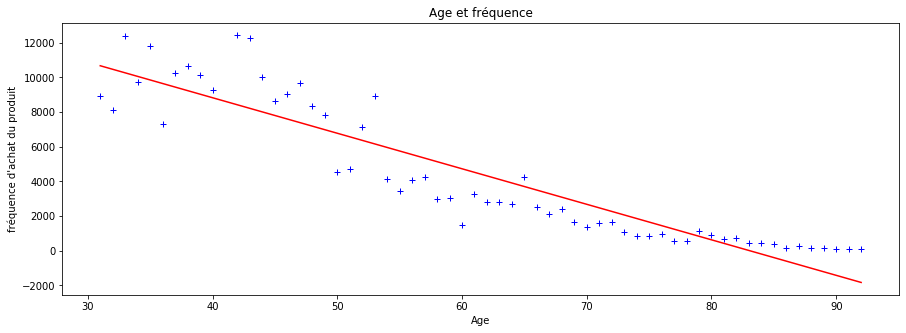

In [62]:
plt.figure(1, figsize=(15, 5))
plt.plot(a30.index, a30, color = 'blue', marker = '+', linestyle = 'none')
plt.plot(a30.index, linea30, color = 'red')
plt.title('Age et fréquence')
plt.xlabel('Age')
plt.ylabel("fréquence d'achat du produit")
print('le modèle linéaire est de la forme : y = ax + b')
print('et a =',slopea30)
print('avec b =', intercepta30)
print('et un R² de ', r_valuea30**2)

Value of R-2 is predicted 0.84 means 84% so this is very good linear regression model.

In [63]:
stat_a30 = {'pearson' : sp.stats.pearsonr(a30,a30.index)}
pd.DataFrame(stat_a30).round(2).rename(index={0:'Valeur du test',1:'P-Value'})


,pearson
Valeur du test,-0.92
P-Value,0.00


La valeur de R-2 est prédite 0,84, ce qui signifie 80 %, ce qui constitue un bon modèle de régression linéaire négative. 

La fréquence d'achat des clients plus âgés est moins élevée que celle des jeunes clients.

Les clients âgés utilisent et achètent uniquement des choses spécifiques. 

# d. Corrélation entre age et panier moyen

In [64]:
panier = ventes_1.groupby(['age','session_id']).id_prod.count()
panier = pd.DataFrame(panier).swaplevel(0, 1, axis=0).reset_index()
panier = panier.groupby('age').id_prod.mean().round(1)
slope3, intercept3, r_value3, p_value3, std_err3 = sp.stats.linregress(panier.index,panier)
line3 = slope3*panier.index+intercept3

le modèle linéaire est de la forme : y = ax + b
et a = -0.010962406015037594
avec b = 2.351398496240601
et un R² de  0.3394423677957023


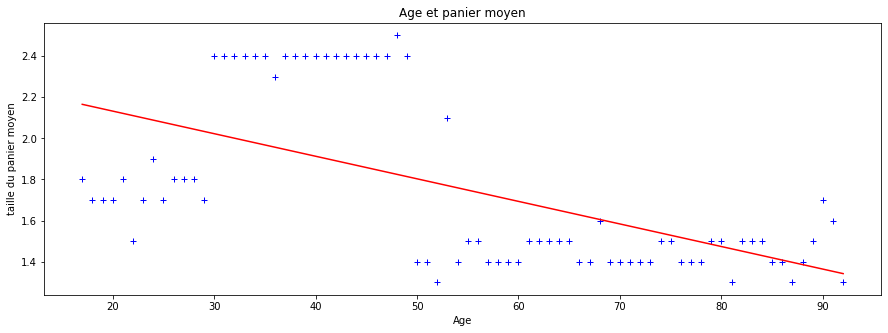

In [65]:
plt.figure(1, figsize=(15, 5))
plt.plot(panier.index, panier, color = 'blue', marker = '+', linestyle = 'none')
plt.plot(panier.index, line3, color = 'red')
plt.title('Age et panier moyen')
plt.xlabel('Age')
plt.ylabel("taille du panier moyen")
print('le modèle linéaire est de la forme : y = ax + b')
print('et a =',slope3)
print('avec b =', intercept3)
print('et un R² de ', r_value3**2)

Value of R-2 is predicted 0.33 means 33% so this is not good linear regression model.

In [66]:
stat_panier = {'pearson' : sp.stats.pearsonr(panier,panier.index)}
pd.DataFrame(stat_panier).round(2).rename(index={0:'Valeur du test',1:'P-Value'})

,pearson
Valeur du test,-0.58
P-Value,0.00


La valeur de R-2 est prédite 0,33, ce qui signifie 33 %, ce qui constitue un faible modèle de régression linéaire négative. 
Il y a pas une corrélation entre l'âge et le panier moyen. 

# e. Corrélation entre age et catégorie de produit

In [67]:
#variable qualitative:
def annova(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

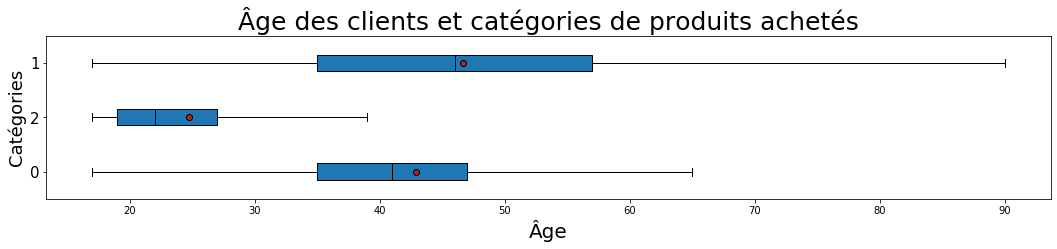

Rapport de corrélation: 11.899999999999999 %


In [68]:
boxplot(ventes_2, "categ", "age")
plt.title("Âge des clients et catégories de produits achetés", fontsize=25)
plt.xlabel("Âge", fontsize=20) 
plt.ylabel("Catégories", fontsize=18)
plt.yticks(fontsize=15) ; plt.show()

print("Rapport de corrélation:", 100*round(annova(ventes_2["categ"], ventes_2["age"]), 3), "%")

Rapport de corrélation: 11.89 %

Avec un taux de corrélation d'environ 12%, nous pouvons observer qu'il existe une corrélation entre l'âge des clients et les catégories de produits achetés : 

on remarque que la boîte à moustaches de catégorie 2 se distingue des deux autres.  La catégorie 2 s'adresse généralement à une clientèle plus jeune, entre 18 et 25 ans, alors que les moyennes d'âge des catégories 0 et 1 semblent plus homogènes, et intéressent apparemment tous les types de clients, quel que soit leur âge!